<a href="https://colab.research.google.com/github/MOISECHRIST/Machine-Learning/blob/main/TP1_INF372_MLP_Keras_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP1 INF372 : APPRENTISSAGE SUPERVISE ET NON SUPERVISE

## Membre du groupe :
- FOSSI TALLA JORDANE (20U2878)
- MAKOU FOKOUA PATRICIA (21T2446)
- MEKA MOISE CHRISTIAN JUNIOR (21T2561)
- RUDY TCHAMBA TCHAPTCHE ITIEL (21T2981)

## Objectif du TP

Il s'agit d'implémenter un MLP (MultiLayer Perceptron) pour la classification des données du dataset MNIST qui est un ensemble d'images de chiffres manuscrit. L'idée étant à partir d'une image manuscrite, de prédire de quel chiffre il s'agit celà en utilisant le MLP. \
Pour se faire, nous allons procéder en plusieurs étapes :
1. Importation des données et leurs séparation en données Train-Valid-Test
2. Prétraitement de l'ensemble des données
3. Définition d'une architecture pour le MLP
4. Implémentation du modèle
5. Evaluation du modèle obtenu

Dans le cadre de cet exercice, nous utiliseron les packages *tensorflow* et *keras*

## 1- Importation des données et séparation en Train-Valid-Test

In [2]:
### Chargement des packages
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

In [3]:
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['image.cmap'] = 'gray'

On défini une procédure seed_random() qui permettra de fixer un état aléatoire et ainsi rendre la construction de ce modèle reproductible.
En effet lorsque l'on défini un seed dans une cellule du notebook, elle n'est valable que pour cette cellule.
Pour résoudre ce problème, nous avons défini une procédure seed_random() qui contient en son sein la définition de notre seed.
Nous allons appeler cette procédure à chaque fois que nous aurons besoin de faire un choix de valeurs aléatoires.

In [4]:
SEED_VALUE = 42
def seed_random():

    # Fix seed to make training deterministic.
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)

In [5]:
#On charge les données de mnist
(X_train_all, y_train_all), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Etant donné que le trainset et le validset doivent être représentative, au lieu de considérer les 10000 premières images du train_all pour construire le validset comme l'indique le tutoriel, nous avons désidé de prendre 10000 valeurs aléatoire dans le train_all pour constituer notre validset.  
Pour rendre notre expérience reproductible nous allons faire appele à la procédure seed_random()

In [6]:
#On défini un état aléatoire
seed_random()

#On sélectionne les 10000 observations pour le validset
id_valid=random.sample(range(X_train_all.shape[0]), 10000)
X_valid = X_train_all[id_valid]
y_valid = y_train_all[id_valid]

#On sélectionne le reste pour le Trainset
id_train=np.setdiff1d(np.arange(0, X_train_all.shape[0]), id_valid)
X_train = X_train_all[id_train]
y_train = y_train_all[id_train]

#On affiche les dimmensions de nos ensembles de données Train-Valid-Test
print("Train : ",X_train.shape)
print("Valid : ",X_valid.shape)
print("Test : ",X_test.shape)

Train :  (50000, 28, 28)
Valid :  (10000, 28, 28)
Test :  (10000, 28, 28)


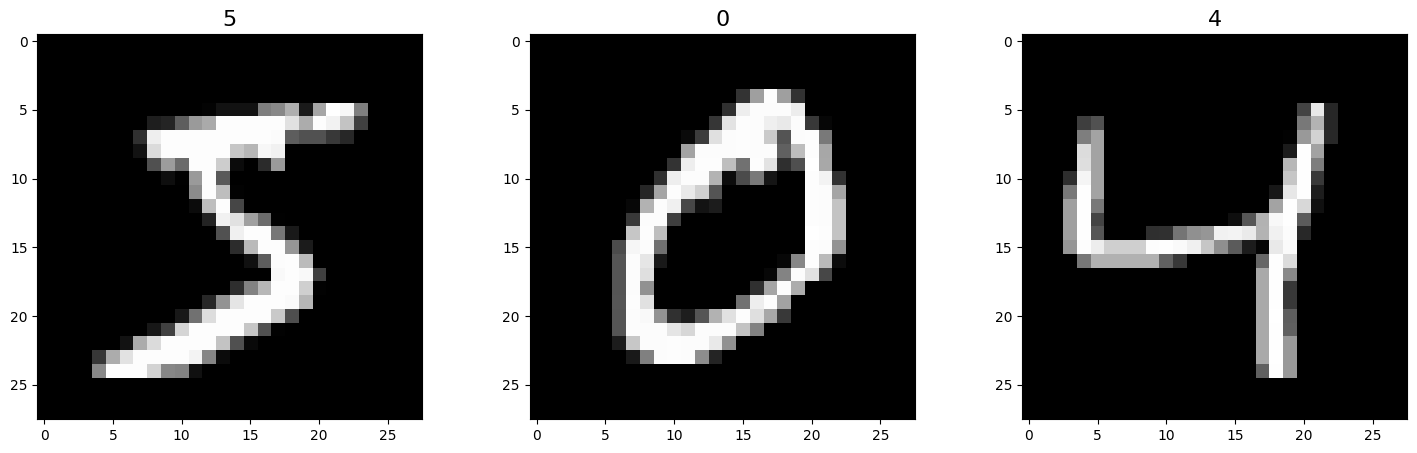

In [7]:
#On affiche en suite quelques images du trainset
plt.figure(figsize=(18, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.axis(True)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

## 2- Prétraitement des ensembles de données

### 2.1 Ensemble de données d'entrée

Les données d'entrées étant des images 28x28, les utiliser de façon bute (données en 2D) dans notre MLP sera impossible. Une approche naïve serait de les redimensionner dans un espace à une dimension. \
En suite nous allons normaliser nos données d'entrées pour avoir des données dans l'intervalle [0;1]

In [8]:
#Normalisation des images
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
X_train = X_train.astype("float32") / 255

X_test = X_test.reshape((X_test.shape[0], 28 * 28))
X_test = X_test.astype("float32") / 255

X_valid = X_valid.reshape((X_valid.shape[0], 28 * 28))
X_valid = X_valid.astype("float32") / 255

### 2.2 Données de sortie

Pour prétraiter les données de sortie (classes 1, 2, 3, ...) nous allons utiliser le one hot encoding qui va transformer les chiffres de sortie de MNIST en des vecteur de bit tel que seul un bit sera à 1 le reste à zéro. Et où si le i-ième bit est 1 alors celà correspond à la classe i-1 \
Exemple : 0 ===> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] \
Celà impliquera l'utilisation de la fonction d'activation _softmax_

In [9]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test  = to_categorical(y_test)

for i in range(3):
    print(y_train[i])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## 3- Architecture du modèle MLP

Notre réseau de neurones sera constitué de :
- Une couche d'entrée de 780 neurones car nos images de 28x28 ont été redimensionné en vecteur de longeur 780
- Deux couches cachées de 128 neurones chacune et une fonction d'activation relu
- Une couche de sortie constitué de 10 neurones auquels on appliquera la fonction softmax pour avoir des sortie suivant une distribution de probabilité

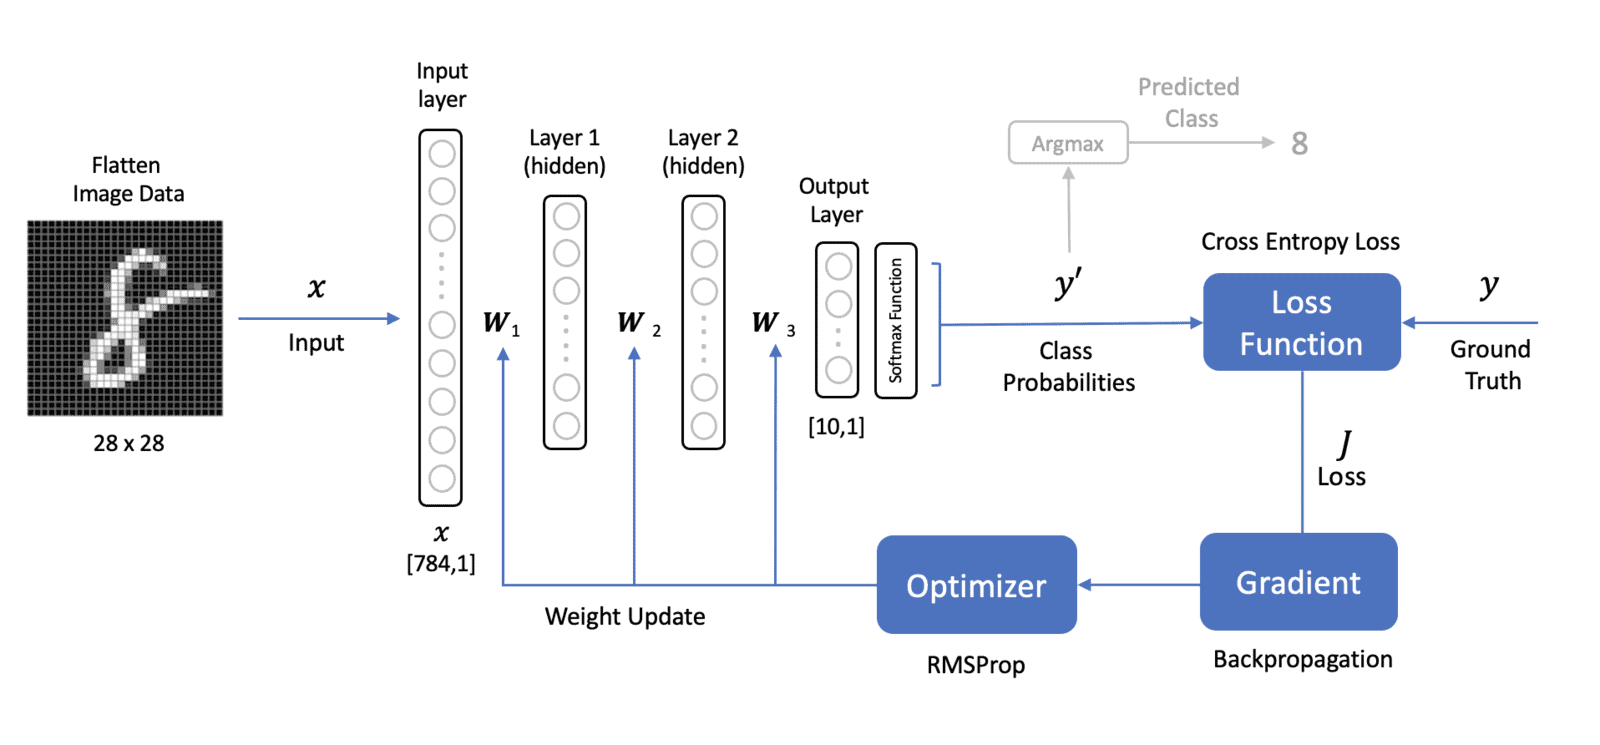

## 4- Implémentation du modèle

### 4.1- Construction du modèle

Avec tensorflow creer un modèle MPL revient a créer un objet qui Sequentiel au quel on peut ajouter des couches qui sont des couches denses c'est à dire que les neurones seront entièrement connecté \
Dans notre cas il aura 3 couches :
- Une couche dense de 128 neurones avec pour entré notre jeu de données Train
- Une seconde couche de 128 neurones connecté à la précedente
- Une Troisième couche dense de 10 neurones qui representera notre couche de sortie \
On remarque la couche d'entré mentionné dans l'architecture est implicitement substitué aux données d'entrées

In [10]:
#On instancie un objet Sequentiel
model = tf.keras.Sequential()

#On construit le modèle défini plus haut
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10,  activation="softmax"))

In [11]:
#On visualise un résumé du modèle construit
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (462.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


On remarque qu'ici que le modèle comprend un nombre total de parametres de 118282 qui seront tous entrainés

### 4.2 Compilation du modèle

A présent nous allons définir les paramètres d'apprentissage de notre modèle c'est à dire la métrique pour évaluer le modèle, la fonction d'optimisation et l'optimiseur. \
Dans le cadre de ce modèle nous allons utiliser :
- L'optimiseur : _RMSProp (Root Mean Square Propagation)_ qui est l'algorithme d'optimisation utilisé pour les réseau de neurone profond résolvant les problèmes du SGD (Stockastic Gradient Descent)
- La fonction de perte : _categorical_crossentropy_ car nos sortie sont des catégories à plus de deux classes et comme nous avions encoder nos données plus haut avec one hot nous ne pouvons donc pas utiliser le _sparse_categorical_crossentropy_ car il est adapté aux catégorie encodé par des chiffres (0, 1, 2, ...) ou _binary_crossentropy_ qui est adapté à la classification binaire.
- Metric : _accuracy_ qui va permettre de visualiser la qualité de l'apprentissage

In [12]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### 4.3 Entrainement du modèle

On ajoute le early stopping ici pour éviter le sur apprentissage du modèle

In [13]:
#Entrenement du modèle
training_results = model.fit(X_train,
                             y_train,
                             epochs=21,
                             batch_size=64,
                             validation_data=(X_valid, y_valid))

Epoch 1/21
782/782 [==============================] - 5s 4ms/step - loss: 0.2813 - accuracy: 0.9180 - val_loss: 0.1978 - val_accuracy: 0.9415
Epoch 2/21
782/782 [==============================] - 3s 4ms/step - loss: 0.1208 - accuracy: 0.9637 - val_loss: 0.1316 - val_accuracy: 0.9598
Epoch 3/21
782/782 [==============================] - 4s 5ms/step - loss: 0.0846 - accuracy: 0.9739 - val_loss: 0.1129 - val_accuracy: 0.9680
Epoch 4/21
782/782 [==============================] - 3s 3ms/step - loss: 0.0639 - accuracy: 0.9803 - val_loss: 0.0955 - val_accuracy: 0.9744
Epoch 5/21
782/782 [==============================] - 3s 3ms/step - loss: 0.0515 - accuracy: 0.9842 - val_loss: 0.0909 - val_accuracy: 0.9753
Epoch 6/21
782/782 [==============================] - 3s 3ms/step - loss: 0.0414 - accuracy: 0.9869 - val_loss: 0.0915 - val_accuracy: 0.9761
Epoch 7/21
782/782 [==============================] - 3s 4ms/step - loss: 0.0331 - accuracy: 0.9897 - val_loss: 0.0915 - val_accuracy: 0.9761
Epoch 

In [14]:
#Visualisation des résultats de l'entrainement
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, 20])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

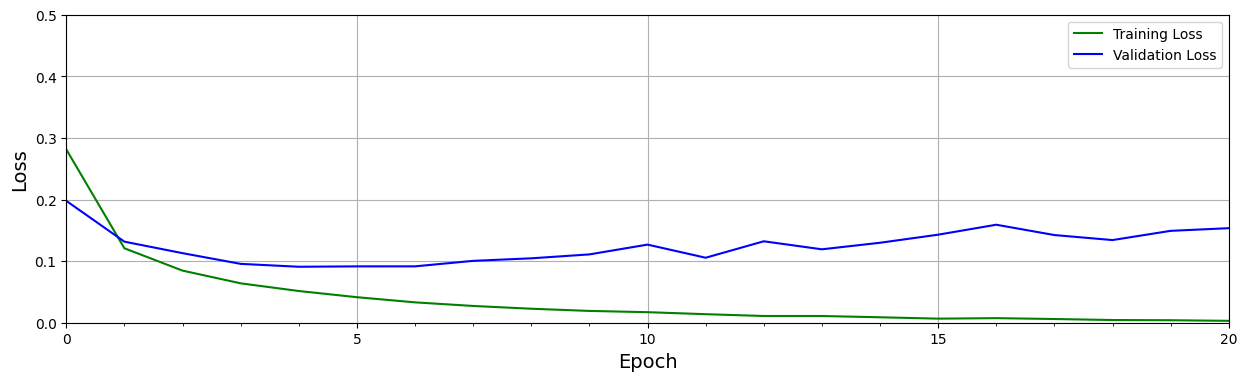

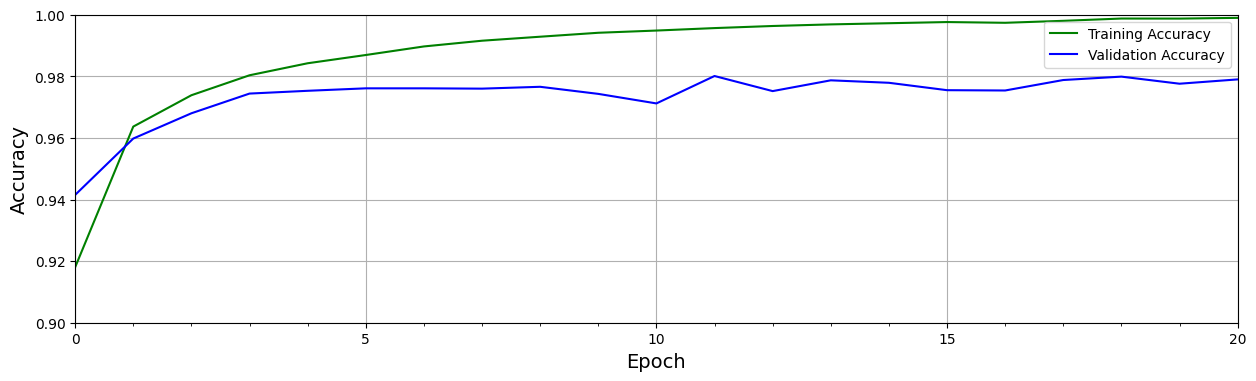

In [15]:
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 0.5],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.9, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

Du premier graphique, on observe une tendance décroissante des deux fonctions loss (validation et Train) jusqu'à la 5ieme epoch. Cette tendance est changé pour la fonction loss des données de validations qui elle va plutôt avoir une tendance croissante après la 5ieme. Ce qui fait penser à un surapprentissage du modèle qui est encore plus visible avec le second graphique qui a un accuracy prensque à 100% pour le train contre une valeur entre 96% et 98% pour les données de validations. Celà montre que le modèle est entrain d'apprendre par coeurs les données d'entrainement.

Epoch 1/21
782/782 [==============================] - 3s 4ms/step - loss: 0.2758 - accuracy: 0.9202 - val_loss: 0.1836 - val_accuracy: 0.9449
Epoch 2/21
782/782 [==============================] - 3s 4ms/step - loss: 0.1151 - accuracy: 0.9653 - val_loss: 0.1258 - val_accuracy: 0.9605
Epoch 3/21
782/782 [==============================] - 3s 3ms/step - loss: 0.0791 - accuracy: 0.9759 - val_loss: 0.1065 - val_accuracy: 0.9694
Epoch 4/21
782/782 [==============================] - 3s 3ms/step - loss: 0.0614 - accuracy: 0.9814 - val_loss: 0.0979 - val_accuracy: 0.9716
Epoch 5/21
782/782 [==============================] - 3s 3ms/step - loss: 0.0498 - accuracy: 0.9846 - val_loss: 0.0844 - val_accuracy: 0.9756
Epoch 6/21
782/782 [==============================] - 3s 4ms/step - loss: 0.0400 - accuracy: 0.9876 - val_loss: 0.0909 - val_accuracy: 0.9757
Epoch 7/21
782/782 [==============================] - 3s 4ms/step - loss: 0.0318 - accuracy: 0.9901 - val_loss: 0.0994 - val_accuracy: 0.9746
Epoch 

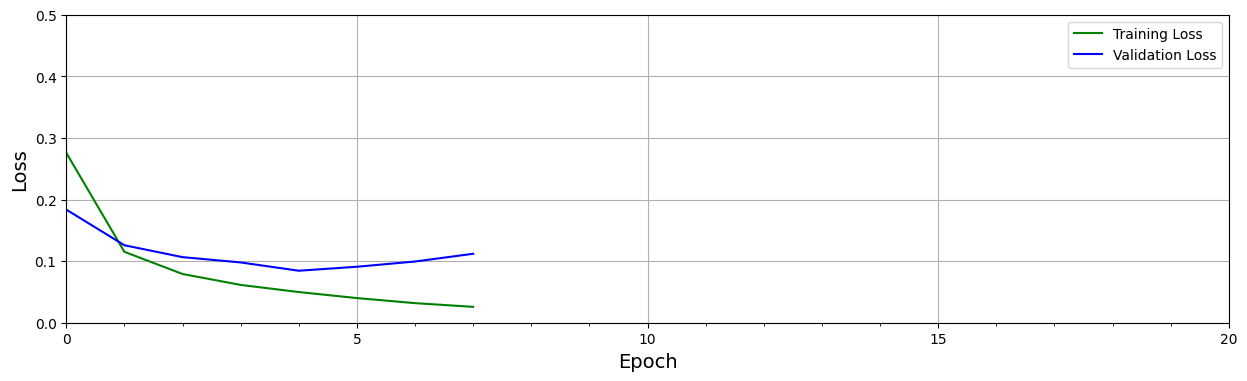

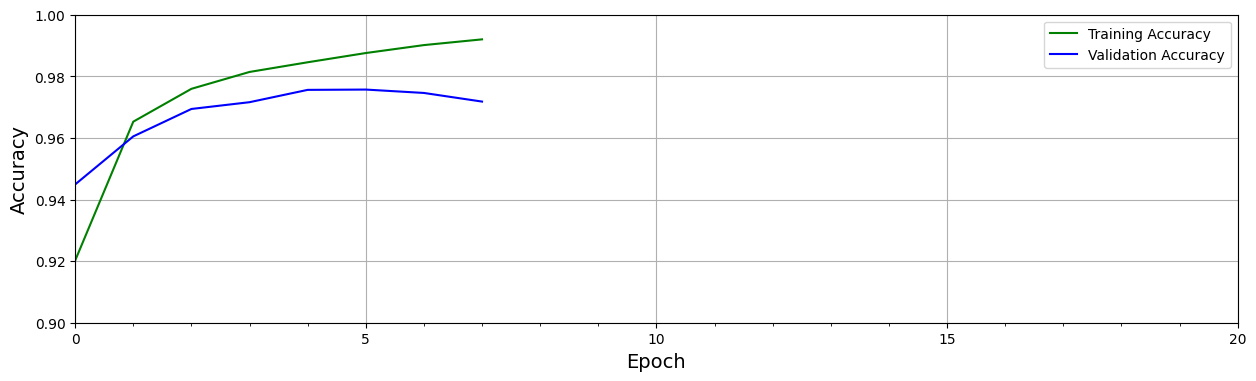

In [16]:
# On instancie un objet Sequentiel
model = tf.keras.Sequential()

# On construit le modèle défini plus haut
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10,  activation="softmax"))

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# On instancie EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Entraînement du modèle avec EarlyStopping
training_results = model.fit(X_train,
                             y_train,
                             epochs=21,
                             batch_size=64,
                             validation_data=(X_valid, y_valid),
                             callbacks=[early_stopping])

#Visualisation de l'entrainement
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 0.5],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.9, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

Mais après avoir appliqué un early stopping on constate que l'entrainement c'est arrêté à la 8ieme epoch ce qui confirme l'observation faite plus haut.

## 5- Evaluation du modèle

In [17]:
predictions = model.predict(X_test)
index = np.random.randint(1,X_test.shape[0])
print('Données réels du testset : ',y_test[index])
print('\n');
print('Predictions pour chaque classe:\n')
for i in range(10):
    print('digit:', i, ' probabilité: ', predictions[index][i])

313/313 [==============================] - 1s 1ms/step
Données réels du testset :  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


Predictions pour chaque classe:

digit: 0  probabilité:  3.1928956e-11
digit: 1  probabilité:  2.854179e-10
digit: 2  probabilité:  0.9999918
digit: 3  probabilité:  4.0664027e-08
digit: 4  probabilité:  4.7882677e-16
digit: 5  probabilité:  7.893683e-14
digit: 6  probabilité:  6.9278167e-18
digit: 7  probabilité:  8.231345e-06
digit: 8  probabilité:  8.104452e-09
digit: 9  probabilité:  1.306356e-08


Après avoir testé le modèle avec les données de test nous allons ressortir les différentes étiquettes de sortie  

In [18]:
predicted_labels = [np.argmax(i) for i in predictions]
y_test_labels = [np.argmax(i) for i in y_test]

Pour finir nous construisons une matrice de confusion qui permettra de visualiser les écarts entre les données prédites du testset et les labels réels de notre testset

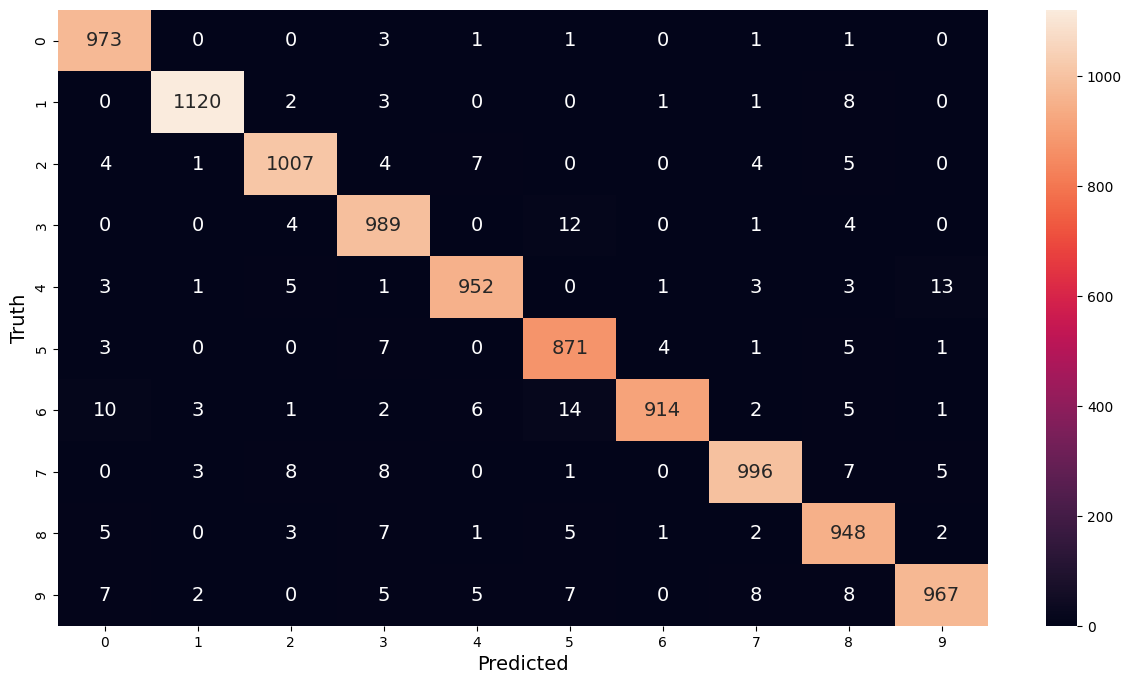

In [19]:
cm = tf.math.confusion_matrix(labels=y_test_labels, predictions=predicted_labels)

# Visualiser la matrice de confusion obtenue avec un heatmap.
plt.figure(figsize=[15, 8])
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

On observe que la majeure partie des données du test ont été bien prédites pour chacune des classes

In [20]:
sum_col=[]
sum_line=[]
for index in range(cm.shape[0]):
  sum_col.append(np.sum(cm[:,index]))
  sum_line.append(np.sum(cm[index,:]))
df=[]
for index in range(cm.shape[0]):
  res=dict()
  precision=cm[index,index]/sum_col[index]
  rappel=cm[index,index]/sum_line[index]
  f1score = 1/((1/2)*((1/precision)+(1/rappel)))
  res["Precision"]=float(precision)
  res["Rappel"]=float(rappel)
  res["F1Score"]=float(f1score)
  res["Classe"]=str(index)
  df.append(res)

import pandas as pd

df=pd.DataFrame(df)

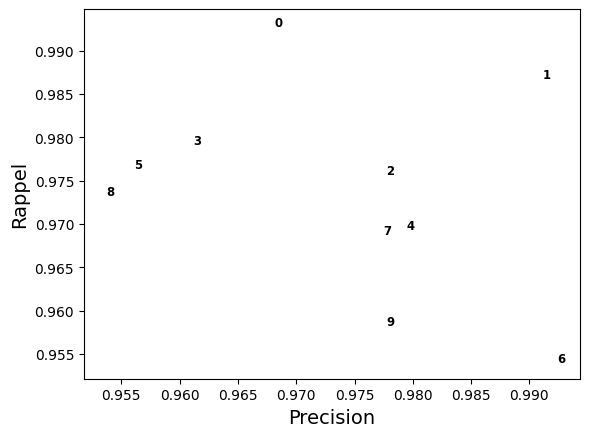

In [21]:
# Création du graphique de dispersion
scatter = sns.scatterplot(data=df, x='Precision', y='Rappel', color='white')

# Ajout des étiquettes de données
for line in range(0,df.shape[0]):
     scatter.text(df.Precision[line], df.Rappel[line], df.Classe[line], horizontalalignment='left', size='small', color='black', weight='semibold')

# Affichage du graphique
plt.show()

In [30]:
#Enregistrement du modèle
model.save('MNIST_MLP_Keras_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
